In [1]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from imports.data import CCV3
from imports.data_track import CCV1
from torch_geometric.data import DataLoader 
from imports.models import Net_DE, Net_GAT, Net_Trans
from imports.model import Net_CTrans
from torch_geometric.nn import knn_graph

import numpy as np
import awkward as ak
import time
from imports.Agglomerative import Aggloremative

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
testpath = '/vols/cms/mm1221/Data/mix/test/'
# Load test data
data_LC = CCV3(testpath, max_events=2000)
LC_loader = DataLoader(data_LC, batch_size=1, shuffle=False, follow_batch=['x'])

testpath = '/vols/cms/mm1221/Data/mix/test/'
# Load test data
data_track = CCV1(testpath, max_events=500)
track_loader = DataLoader(data_track, batch_size=1, shuffle=False, follow_batch=['x'])


### Loading data


  0%|                                                     | 0/1 [02:34<?, ?it/s]
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Reached 2000!
### Loading tracksters data


  0%|                                                     | 0/1 [00:00<?, ?it/s]

/vols/cms/mm1221/Data/mix/test/raw/test.root


  0%|                                                     | 0/1 [00:44<?, ?it/s]

Reached 500 events!


In [3]:
# Also load explicitely, used for analysis and plots
data_path = '/vols/cms/mm1221/Data/mix/test/raw/test.root'
#data_path = '/vols/cms/mm1221/Data/100k/5pi/test/raw/test.root' 
data_file = uproot.open(data_path)

ass = data_file['associations']['tsCLUE3D_recoToSim_CP'].array()
scores = data_file['associations']['tsCLUE3D_recoToSim_CP_score'].array()
Track_ind = data_file['tracksters']['vertices_indexes'].array()
GT_ind = data_file['simtrackstersCP']['vertices_indexes'].array()
GT_mult = data_file['simtrackstersCP']['vertices_multiplicity'].array()
GT_bc = data_file['simtrackstersCP']['barycenter_x'].array()
energies = data_file['clusters']['energy'].array()
LC_x = data_file['clusters']['position_x'].array()
LC_y = data_file['clusters']['position_y'].array()
LC_z = data_file['clusters']['position_z'].array()
LC_eta = data_file['clusters']['position_eta'].array()
MT_ind = data_file['trackstersMerged']['vertices_indexes'].array()


#1.3 Filter so get rid of events with 0 calo particles
t_bx = data_file['tracksters']['barycenter_x'].array()


skim_mask = []
for e in t_bx:
    if len(e) == 0:
        skim_mask.append(False)
    else:
        skim_mask.append(True)

Track_ind = Track_ind[skim_mask]
GT_ind = GT_ind[skim_mask]
GT_mult = GT_mult[skim_mask]
energies = energies[skim_mask]
LC_x = LC_x[skim_mask]
LC_y = LC_y[skim_mask]
LC_z = LC_z[skim_mask]
LC_eta = LC_eta[skim_mask]
MT_ind = MT_ind[skim_mask]
ass = ass[skim_mask]
scores=scores[skim_mask]





In [4]:
pgid = data_file['simtrackstersCP']['pdgID'].array()


skim_mask = []
for e in t_bx:
    if len(e) == 0:
        skim_mask.append(False)
    else:
        skim_mask.append(True)
        
pgid = pgid[skim_mask]

In [5]:
import awkward as ak

def filter_repeated_indexes(GT_ind, GT_mult):
    """
    Given:
       - GT_ind: an awkward array (or list of lists) of indexes for one event.
       - GT_mult: an awkward array (or list of lists) of multiplicity values (same shape as GT_ind).
    
    For any index that appears in more than one sub-array, keep only the occurrence with the
    smallest multiplicity, and set that multiplicity to 1.0. All other occurrences are removed.
   
    Returns:
       new_GT_ind, new_GT_mult  
         Both are returned as <class 'awkward.highlevel.Array'>.
    """
    # 1. Record all occurrences of each index.
    occurrences = {}
    for sub_i, (sub_ind, sub_mult) in enumerate(zip(GT_ind, GT_mult)):
        for pos, (val, mult) in enumerate(zip(sub_ind, sub_mult)):
            occurrences.setdefault(val, []).append((sub_i, pos, mult))
    
    # 2. Mark occurrences to remove and those to update.
    removals = set()
    update_to_one = set()
    
    for index_val, occ_list in occurrences.items():
        if len(occ_list) > 1:
            occ_list_sorted = sorted(occ_list, key=lambda x: x[2])  # Sort by multiplicity
            kept_occ = occ_list_sorted[0]  # Keep lowest multiplicity
            update_to_one.add((kept_occ[0], kept_occ[1]))
            for occ in occ_list_sorted[1:]:
                removals.add((occ[0], occ[1]))
    
    # 3. Reconstruct new GT_ind and GT_mult by filtering out the removals.
    new_GT_ind = []
    new_GT_mult = []
    for sub_i, (sub_ind, sub_mult) in enumerate(zip(GT_ind, GT_mult)):
        new_sub_ind = []
        new_sub_mult = []
        for pos, (val, mult) in enumerate(zip(sub_ind, sub_mult)):
            if (sub_i, pos) in removals:
                continue
            new_sub_ind.append(val)
            new_sub_mult.append(1.0 if (sub_i, pos) in update_to_one else mult)
        new_GT_ind.append(new_sub_ind)
        new_GT_mult.append(new_sub_mult)
    
    # Convert lists to awkward arrays
    return ak.Array(new_GT_ind), ak.Array(new_GT_mult)

def filter_repeated_indexes_for_events(all_GT_ind, all_GT_mult):
    """
    Given a list of events, each with its GT_ind and GT_mult (lists of sub-arrays),
    apply filter_repeated_indexes to each event.
    
    Args:
        all_GT_ind: List of events. Each event is an awkward array (or list of sub-arrays) of indexes.
        all_GT_mult: List of events. Each event is an awkward array (or list of sub-arrays) of multiplicity values.
    
    Returns:
        new_all_GT_ind, new_all_GT_mult: Awkward arrays (one per event) of filtered GT_ind and GT_mult.
    """
    new_all_GT_ind = []
    new_all_GT_mult = []
    
    # Loop over each event
    for event_ind, event_mult in zip(all_GT_ind, all_GT_mult):
        new_event_ind, new_event_mult = filter_repeated_indexes(event_ind, event_mult)
        new_all_GT_ind.append(new_event_ind)
        new_all_GT_mult.append(new_event_mult)
    
    # Convert to awkward arrays
    return ak.Array(new_all_GT_ind), ak.Array(new_all_GT_mult)

GT_ind_nodup, GT_mult_nodup = filter_repeated_indexes_for_events(GT_ind, GT_mult)

import awkward as ak

import awkward as ak

# Create new lists to store the filtered results
# This makes sure GT_ind, MT_ind, Recon_ind have the same indices
filtered_GT_ind = []
filtered_GT_mult = []
filtered_MT_ind = []


for event_idx, track_indices in enumerate(data_LC.stsCP_vertices_indexes):
    # Flatten the current event's track indices and convert to a set
    track_flat = set(ak.flatten(track_indices).tolist())  # Ensure it contains only integers
    
    # Filter GT_ind and GT_mult for the current event, preserving structure
    event_GT_ind = GT_ind[event_idx]
    event_GT_mult = GT_mult[event_idx]
    filtered_event_GT_ind = []
    filtered_event_GT_mult = []
    for sublist_ind, sublist_mult in zip(event_GT_ind, event_GT_mult):
        filtered_sublist_ind = [idx for idx in sublist_ind if idx in track_flat]
        filtered_sublist_mult = [mult for idx, mult in zip(sublist_ind, sublist_mult) if idx in track_flat]
        filtered_event_GT_ind.append(filtered_sublist_ind)
        filtered_event_GT_mult.append(filtered_sublist_mult)

    # Filter MT_ind for the current event, preserving structure
    event_MT_ind = MT_ind[event_idx]
    filtered_event_MT_ind = []
    for sublist in event_MT_ind:
        filtered_sublist = [idx for idx in sublist if idx in track_flat]
        filtered_event_MT_ind.append(filtered_sublist)

    # Append filtered results
    filtered_GT_ind.append(filtered_event_GT_ind)
    filtered_GT_mult.append(filtered_event_GT_mult)
    filtered_MT_ind.append(filtered_event_MT_ind)

# Convert the filtered results back to awkward arrays
GT_ind_filt = ak.Array(filtered_GT_ind)
GT_mult_filt = ak.Array(filtered_GT_mult)
MT_ind_filt = ak.Array(filtered_MT_ind)

# Create new lists to store the filtered results
# This makes sure GT_ind, MT_ind, Recon_ind have the same indices
filtered_GT_ind_nodup = []
filtered_GT_mult_nodup = []



for event_idx, track_indices in enumerate(data_LC.stsCP_vertices_indexes):
    # Flatten the current event's track indices and convert to a set
    track_flat = set(ak.flatten(track_indices).tolist())  # Ensure it contains only integers
    
    # Filter GT_ind and GT_mult for the current event, preserving structure
    event_GT_ind = GT_ind_nodup[event_idx]
    event_GT_mult = GT_mult_nodup[event_idx]
    filtered_event_GT_ind = []
    filtered_event_GT_mult = []
    for sublist_ind, sublist_mult in zip(event_GT_ind, event_GT_mult):
        filtered_sublist_ind = [idx for idx in sublist_ind if idx in track_flat]
        filtered_sublist_mult = [mult for idx, mult in zip(sublist_ind, sublist_mult) if idx in track_flat]
        filtered_event_GT_ind.append(filtered_sublist_ind)
        filtered_event_GT_mult.append(filtered_sublist_mult)



    # Append filtered results
    filtered_GT_ind_nodup.append(filtered_event_GT_ind)
    filtered_GT_mult_nodup.append(filtered_event_GT_mult)


# Convert the filtered results back to awkward arrays
GT_ind_filt_nodup = ak.Array(filtered_GT_ind_nodup)
GT_mult_filt_nodup = ak.Array(filtered_GT_mult_nodup)





In [6]:

modelLC = Net_DE(128,3, dropout=0.3, contrastive_dim=16, k=64)
#checkpoint= torch.load('/vols/cms/mm1221/hgcal/Mixed/LC/Fraction/runs/DEC/hd128nl3cd128k72/best_model.pt',  map_location=torch.device('cpu'))
checkpoint= torch.load('/vols/cms/er421/hgcal/code/code/Mixed/LC/Full/results/hd128nl3cd16k64/epoch-100.pt',  map_location=torch.device('cpu'))
modelLC.load_state_dict(checkpoint['model'])  
modelLC.eval() 


Net_DE(
  (lc_encode): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
  )
  (edgeconv_layers): ModuleList(
    (0-2): 3 x DynamicEdgeConv(nn=Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=128, out_features=128, bias=True)
    ), k=64)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
  )
)

In [7]:
modelT = Net_CTrans(128,3, dropout=0.3, contrastive_dim=64, num_heads=16)
checkpoint= torch.load('/vols/cms/mm1221/hgcal/Mixed/Track/NegativeMining/runs/TransNew/hd128nl3cd64k90h16/epoch-94.pt',  map_location=torch.device('cpu'))
#checkpoint= torch.load('/vols/cms/er421/hgcal/code/code/Mixed/LC/Full/results/hd128nl3cd16k64/epoch-100.pt',  map_location=torch.device('cpu'))
modelT.load_state_dict(checkpoint['model'])  
modelT.eval()

Net_CTrans(
  (lc_encode): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
  )
  (transformer_layers): ModuleList(
    (0-2): 3 x GraphTransformerLayer(
      (q_linear): Linear(in_features=128, out_features=128, bias=True)
      (k_linear): Linear(in_features=128, out_features=128, bias=True)
      (v_linear): Linear(in_features=128, out_features=128, bias=True)
      (out_linear): Linear(in_features=128, out_features=128, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (att_dropout): Dropout(p=0.3, inplace=False)
      (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_fe

In [30]:
import time
import numpy as np
from sklearn.metrics.pairwise import cosine_distances  # for cosine distance calculation

all_predictions = []  
start_time = time.time()

# Get predictions for each event
for i, data in enumerate(LC_loader):
    #edge_index = knn_graph(data.x[:, :3], k=98, batch=data.x_batch)
    if i >2000:
        break
    
    predictions = modelLC(data.x,data.x_batch)
    all_predictions.append(predictions[0].detach().cpu().numpy())  

all_predictions = np.array(all_predictions)

# 3.2: Cluster using threshold found in Script A
all_cluster_labels_LC = Aggloremative(all_predictions, threshold=0.13)
#all_cluster_labels = affinity_propagation_clustering(all_predictions, damping=0.6)
"""
all_cluster_labels = mean_shift_clustering(
    all_predictions,
    bandwidth=None,    # Or a numeric value if you already have a good estimate
    quantile=0.2,      # Tweak quantile to control bandwidth estimation
    n_samples=500      # You can limit the sample size if data is large
)
"""

end_time = time.time()

# 3.3: Calculate average inference time
time_diff = end_time - start_time
inference_time = time_diff / len(all_cluster_labels_LC)
print("average inference time:", inference_time)


average inference time: 0.11743142961085527


In [32]:
#4: Calculate Scores and create DF for our model and TICL

#4.1: Turn the cluster labels into our reconstructed tracksters

recon_ind = []

for event_idx, labels in enumerate(all_cluster_labels_LC):
    event_clusters = {} 
    for cluster_idx, cluster_label in enumerate(labels):
        if cluster_label not in event_clusters:
            event_clusters[cluster_label] = []
        event_clusters[cluster_label].append(ak.flatten(data_LC.stsCP_vertices_indexes[event_idx])[cluster_idx])
    recon_ind.append([event_clusters[label] for label in sorted(event_clusters.keys())])

recon_ind_LC = ak.Array(recon_ind)
recon_mult_LC = ak.Array([[[1 for _ in sublist] for sublist in event] for event in recon_ind]) # keep variable for future
# endeavours where the model is able to assign multiple caloparticles to a LC.
Track_mult = ak.Array([[[1 for _ in sublist] for sublist in event] for event in Track_ind]) # keep variable for future
MT_mult_filt = ak.Array([[[1 for _ in sublist] for sublist in event] for event in MT_ind_filt]) # keep variable for future

In [10]:
all_predictions = []  
start_time = time.time()

# Get predictions for each event
for i, data in enumerate(track_loader):
    if i>2000:
        break
    edge_index = knn_graph(data.x[:, :3], k=80, batch=data.x_batch)
    predictions = modelT(data.x, edge_index, data.x_batch)
    all_predictions.append(predictions[0].detach().cpu().numpy())  


# 3.2: Cluster using threshold found in Script A
all_cluster_labels_T = Aggloremative(all_predictions, threshold=0.1)
#all_cluster_labels = affinity_propagation_clustering(all_predictions, damping=0.7)


end_time = time.time()

# 3.3: Calculate average inference time
time_diff = end_time - start_time
inference_time = time_diff / len(all_cluster_labels_T)
print("average inference time:", inference_time)


average inference time: 0.013937921419196102


In [11]:
recon_ind = []

for event_idx, labels in enumerate(all_cluster_labels_T):

    event_clusters = {} 
    
    for cluster_idx, cluster_label in enumerate(labels):
        if cluster_label not in event_clusters:
            event_clusters[cluster_label] = []
        event_clusters[cluster_label].extend(Track_ind[event_idx][cluster_idx])
    
    recon_ind.append([event_clusters[label] for label in sorted(event_clusters.keys())])
recon_ind_T = ak.Array(recon_ind)
recon_mult = ak.Array([[[1 for _ in sublist] for sublist in event] for event in recon_ind]) # keep variable for future

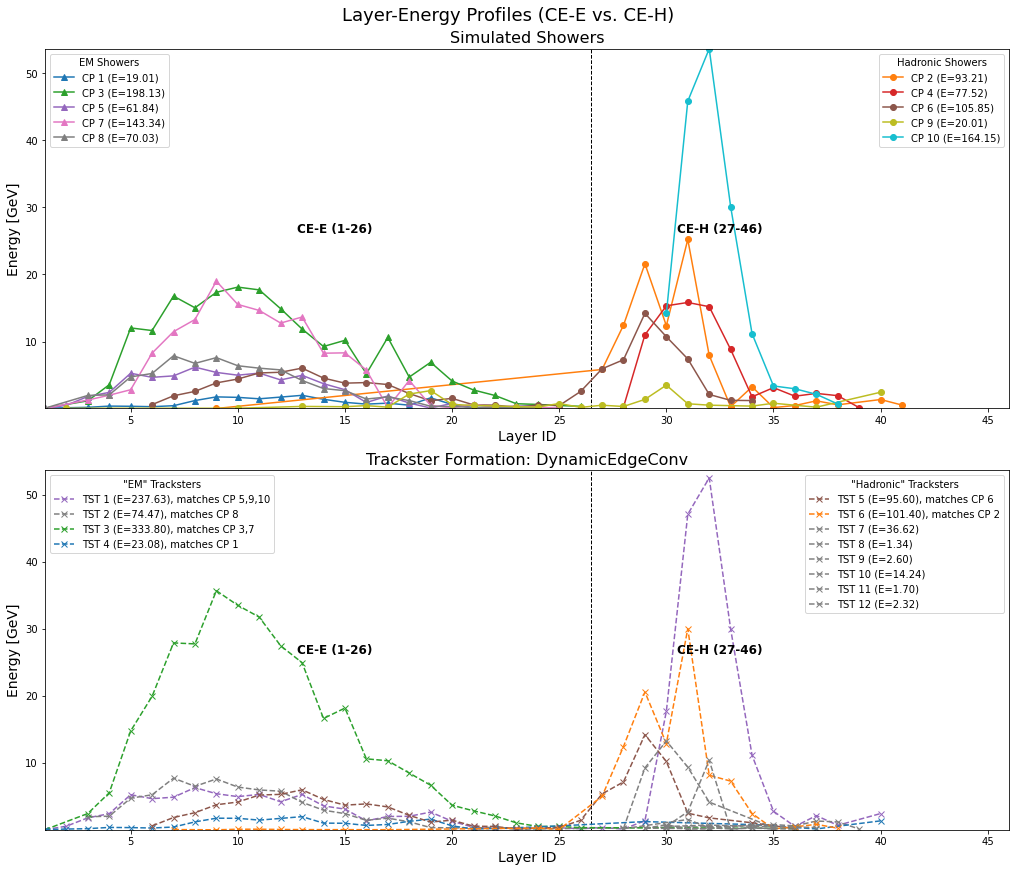

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


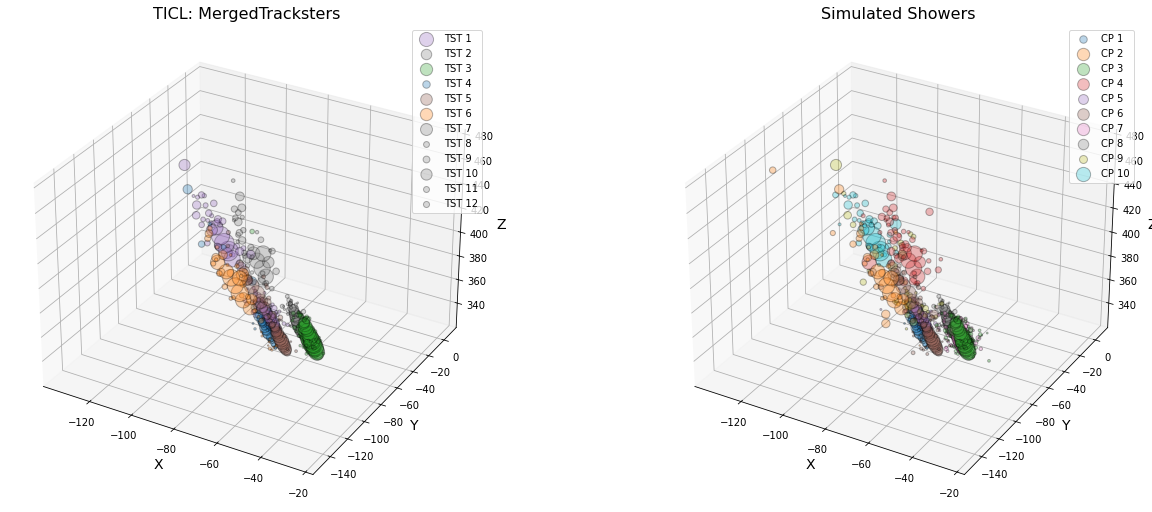

In [36]:
# Plotting longitudinal energy profiles of both simulated and reconstructed showers along with associated pairs.

import matplotlib.colors as mcolors

layer = data_file['clusters']['cluster_layer_id'].array()

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

# Ensure "plots" directory exists
os.makedirs("plots", exist_ok=True)

def calculate_event_profile_data(GT_ind, energies, recon_ind, layer, multi, event_index=0):
    """
    Creates two figures:

    1) A single 2D figure with two subplots, stacked vertically:
       - Top subplot: All Simulated (CaloParticle) showers vs. layer (1..46)
       - Bottom subplot: All Reconstructed (Trackster) showers vs. layer (1..46)
         A dashed vertical line at x=26.5 indicates the boundary between CE-E (1..26)
         and CE-H (27..46).
         We highlight CaloParticles #1, #3, #5, #7, #8 (1-based) and any tracksters
         associated with them (full opacity, placed in a "left" legend). All others
         appear at reduced opacity (in a "right" legend).

    2) A 3D figure with side-by-side subplots:
       - Left: All simulated showers in 3D
       - Right: All reconstructed showers in 3D
    """

    # ---------------------- Setup / Data Extraction ----------------------
    # Tableau colors for distinct color choices
    colors = list(mcolors.TABLEAU_COLORS.values())

    # Extract the data for the chosen event
    caloparticles = GT_ind[event_index]  # Indices for CaloParticles in the event
    tracksters   = recon_ind[event_index]  # Indices for ReconstructedTracksters in the event
    event_energies = energies[event_index]  # Energies for this event
    event_layer_id = layer[event_index]
    event_multi    = multi[event_index]
    event_LC_x     = LC_x[event_index]
    event_LC_y     = LC_y[event_index]
    event_LC_z     = LC_z[event_index]

    # To store the layer profiles
    simulated_profiles = []     # list of DataFrames, one per CP
    reconstructed_profiles = [] # list of DataFrames, one per Trackster

    # For 3D visualization
    cp_lc_pos_all = []
    cp_lc_energies_all = []
    tst_lc_pos_all = []
    tst_lc_energies_all = []

    # Summed energies
    total_cp_energies = []
    total_tst_energies = []

    # For mapping CaloParticles to Tracksters (associations)
    associations = {}

    # ---------------------- Build Simulated (CaloParticle) Profiles ----------------------
    for cp_idx, caloparticle in enumerate(caloparticles):
        cp_lc_layer_id = event_layer_id[caloparticle]
        cp_lc_energies = event_energies[caloparticle] / event_multi[cp_idx]

        df_cp = pd.DataFrame({
            'layer_id': cp_lc_layer_id,
            'energy': cp_lc_energies
        })
        layer_energy_cp = df_cp.groupby('layer_id')['energy'].sum().reset_index()
        simulated_profiles.append(layer_energy_cp)

        cp_lc_pos_all.append([
            event_LC_x[caloparticle],
            event_LC_y[caloparticle],
            event_LC_z[caloparticle]
        ])
        cp_lc_energies_all.append(cp_lc_energies)
        total_cp_energies.append(layer_energy_cp['energy'].sum())

    # Assign each simulated shower a color
    cp_color_map = {
        cp_idx: colors[cp_idx % len(colors)]
        for cp_idx in range(len(simulated_profiles))
    }

    # ---------------------- Build Reconstructed (Trackster) Profiles ----------------------
    for trackster in tracksters:
        tst_lc_layer_id = event_layer_id[trackster]
        tst_lc_energies = event_energies[trackster]

        df_tst = pd.DataFrame({
            'layer_id': tst_lc_layer_id,
            'energy': tst_lc_energies
        })
        layer_energy_tst = df_tst.groupby('layer_id')['energy'].sum().reset_index()
        reconstructed_profiles.append(layer_energy_tst)

        tst_lc_pos_all.append([
            event_LC_x[trackster],
            event_LC_y[trackster],
            event_LC_z[trackster]
        ])
        tst_lc_energies_all.append(tst_lc_energies)
        total_tst_energies.append(layer_energy_tst['energy'].sum())

    # ---------------------- Determine Associations (Sim -> Reco) ----------------------
    for calo_idx, caloparticle in enumerate(caloparticles):
        cp_energy = np.sum(event_energies[caloparticle] / event_multi[calo_idx])
        max_shared_energy = 0.0
        best_tst_idx = None
        for trackster_idx, trackster in enumerate(tracksters):
            shared_det_ids = set(caloparticle).intersection(set(trackster))
            if not shared_det_ids:
                continue
            shared_energy = np.sum(event_energies[list(shared_det_ids)])
            if shared_energy >= 0.5 * cp_energy and shared_energy > max_shared_energy:
                max_shared_energy = shared_energy
                best_tst_idx = trackster_idx

        if best_tst_idx is not None:
            associations[calo_idx] = best_tst_idx

    # ---------------------- 2D Plots (Stacked): True on Top, Reco on Bottom ----------------------
    fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(14, 12), constrained_layout=True)
    fig.suptitle(f"Layer-Energy Profiles (CE-E vs. CE-H)", fontsize=18)

    # We'll compute a single global min/max for both subplots so their y-scales match
    all_sim_energies = [p['energy'] for p in simulated_profiles]
    all_reco_energies = [p['energy'] for p in reconstructed_profiles]
    if all_sim_energies or all_reco_energies:
        all_energies_2d = pd.concat(all_sim_energies + all_reco_energies)
        min_energy_2d = all_energies_2d.min()
        max_energy_2d = all_energies_2d.max()
    else:
        min_energy_2d, max_energy_2d = 0, 1

    # ----- Shared function for drawing vertical line + adapted text -----
    def add_ce_boundary(ax):
        ax.set_xlim(1, 46)
        ax.set_ylim(min_energy_2d, max_energy_2d)
        ax.set_xlabel("Layer ID", fontsize = 14)
        ax.set_ylabel("Energy [GeV]", fontsize = 14)
        # Draw the vertical boundary line
        ax.axvline(x=26.5, color='black', linestyle='--', linewidth=1)
        # Place labels at 30%/70% across and 50% up the axes
        ax.text(0.3, 0.5, "CE-E (1-26)",
                transform=ax.transAxes,
                ha="center", va="center",
                fontsize=12, fontweight="bold")
        ax.text(0.7, 0.5, "CE-H (27-46)",
                transform=ax.transAxes,
                ha="center", va="center",
                fontsize=12, fontweight="bold")

    # ===== Top Subplot: Simulated (Truth) Showers =====
    ax_top.set_title("Simulated Showers", fontsize=16)
    add_ce_boundary(ax_top)

    # Distinguish special CP indices (#1, #3, #5, #7, #8) vs. the rest
    special_cp_set = {1, 3, 5, 7, 8}  # 1-based
    left_handles_top, left_labels_top = [], []
    right_handles_top, right_labels_top = [], []

    for cp_idx, profile in enumerate(simulated_profiles):
        color = cp_color_map[cp_idx]
        label_str = f"CP {cp_idx+1} (E={total_cp_energies[cp_idx]:.2f})"
        if (cp_idx + 1) in special_cp_set:
            line_obj = ax_top.plot(
                profile['layer_id'], profile['energy'],
                marker='^', linestyle='-',
                color=color, alpha=1.0, label=label_str
            )[0]
            left_handles_top.append(line_obj)
            left_labels_top.append(label_str)
        else:
            line_obj = ax_top.plot(
                profile['layer_id'], profile['energy'],
                marker='o', linestyle='-',
                color=color, alpha=1, label=label_str
            )[0]
            right_handles_top.append(line_obj)
            right_labels_top.append(label_str)

    # Place two legends in top subplot
    top_left_legend = ax_top.legend(left_handles_top, left_labels_top,
                                    loc='upper left', title='EM Showers')
    ax_top.add_artist(top_left_legend)
    ax_top.legend(right_handles_top, right_labels_top,
                  loc='upper right', title='Hadronic Showers')

    # ===== Bottom Subplot: Reconstructed Showers =====
    ax_bottom.set_title("Trackster Formation: DynamicEdgeConv", fontsize=16)
    add_ce_boundary(ax_bottom)

    left_handles_bot, left_labels_bot = [], []
    right_handles_bot, right_labels_bot = [], []

    # Trackster side: if it matches any "special CP," highlight
    # (left set). Otherwise, less alpha (right set).
    for tst_idx, profile in enumerate(reconstructed_profiles):
        associated_cp = [cp_idx for cp_idx, assoc_tst in associations.items() if assoc_tst == tst_idx]
        if associated_cp:
            color = cp_color_map[associated_cp[0]]  # pick color of first matched CP
        else:
            color = "gray"

        E_tst = total_tst_energies[tst_idx]
        if associated_cp:
            matching_str = ",".join(str(cp+1) for cp in associated_cp)
            label_str = f"TST {tst_idx+1} (E={E_tst:.2f}), matches CP {matching_str}"
        else:
            label_str = f"TST {tst_idx+1} (E={E_tst:.2f})"

        highlight_this = any(((cp_idx+1) in special_cp_set) for cp_idx in associated_cp)
        alpha_val = 1.0 if highlight_this else 0.6

        line_obj = ax_bottom.plot(
            profile['layer_id'], profile['energy'],
            marker='x', linestyle='--',
            color=color, alpha=1, label=label_str
        )[0]

        if highlight_this:
            left_handles_bot.append(line_obj)
            left_labels_bot.append(label_str)
        else:
            right_handles_bot.append(line_obj)
            right_labels_bot.append(label_str)

    # Place two legends in bottom subplot
    bot_left_legend = ax_bottom.legend(left_handles_bot, left_labels_bot,
                                       loc='upper left', title='"EM" Tracksters')
    ax_bottom.add_artist(bot_left_legend)
    ax_bottom.legend(right_handles_bot, right_labels_bot,
                     loc='upper right', title='"Hadronic" Tracksters')

    # Save the 2D figure with top (sim) + bottom (reco)
    fig.savefig("plots/layer_profiles.png", dpi=300, bbox_inches="tight")

    # ------------------------------ 3D VISUALIZATIONS ------------------------------

    all_energies = np.concatenate(cp_lc_energies_all + tst_lc_energies_all) if (cp_lc_energies_all and tst_lc_energies_all) else [0,1]
    global_min_energy = np.min(all_energies)
    global_max_energy = np.max(all_energies)

    x_lim = [min(event_LC_x), max(event_LC_x)]
    y_lim = [min(event_LC_y), max(event_LC_y)]
    z_lim = [min(event_LC_z), max(event_LC_z)]

    fig3d = plt.figure(figsize=(18, 7), constrained_layout=True)

    # --- 3D: All Reconstructed Showers (now on the left) ---
    ax_3d_reco = fig3d.add_subplot(1, 2, 1, projection='3d')
    for tst_idx, (pos, energies_) in enumerate(zip(tst_lc_pos_all, tst_lc_energies_all)):
        x, y, z = pos
        sizes = np.log1p(np.array(energies_)) * 100
        assoc_cp = [cp_idx for cp_idx, v in associations.items() if v == tst_idx]
        color = cp_color_map[assoc_cp[0]] if assoc_cp else "gray"
        ax_3d_reco.scatter(x, y, z, c=color, alpha=0.3, s=sizes, edgecolors='k',
                           label=f"TST {tst_idx+1}")
    ax_3d_reco.set_xlim(x_lim)
    ax_3d_reco.set_ylim(y_lim)
    ax_3d_reco.set_zlim(z_lim)
    ax_3d_reco.set_title("TICL: MergedTracksters", fontsize=16)
    ax_3d_reco.set_xlabel("X", fontsize=14)
    ax_3d_reco.set_ylabel("Y", fontsize=14)
    ax_3d_reco.set_zlabel("Z", fontsize=14)
    ax_3d_reco.legend()

    # --- 3D: All Simulated Showers (now on the right) ---
    ax_3d_sim = fig3d.add_subplot(1, 2, 2, projection='3d')
    for cp_idx, (pos, energies_) in enumerate(zip(cp_lc_pos_all, cp_lc_energies_all)):
        x, y, z = pos
        sizes = np.log1p(np.array(energies_)) * 100
        color = cp_color_map[cp_idx]
        ax_3d_sim.scatter(x, y, z, c=color, alpha=0.3, s=sizes, edgecolors='k',
                          label=f"CP {cp_idx+1}")
    ax_3d_sim.set_xlim(x_lim)
    ax_3d_sim.set_ylim(y_lim)
    ax_3d_sim.set_zlim(z_lim)
    ax_3d_sim.set_title("Simulated Showers", fontsize=16)
    ax_3d_sim.set_xlabel("X", fontsize=14)
    ax_3d_sim.set_ylabel("Y", fontsize=14)
    ax_3d_sim.set_zlabel("Z", fontsize=14)
    ax_3d_sim.legend()

    fig3d.savefig("plotsDet/3D_MT474.pdf", dpi=300, bbox_inches="tight")
    #fig.savefig("plotsDet/LC474.pdf")
    plt.show()


# Example usage (adjust event_index as needed):
calculate_event_profile_data(
    GT_ind_filt_nodup, energies, MT_ind_filt, layer, GT_mult_filt_nodup,
    event_index=474
)


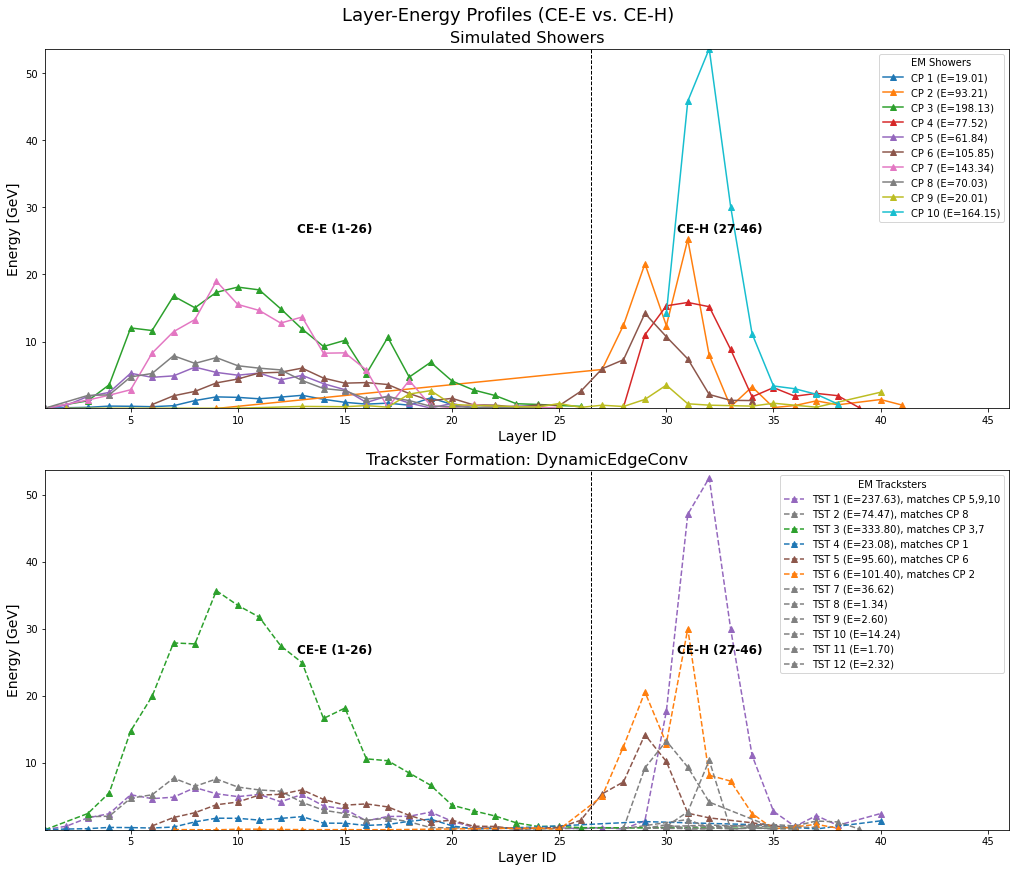

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


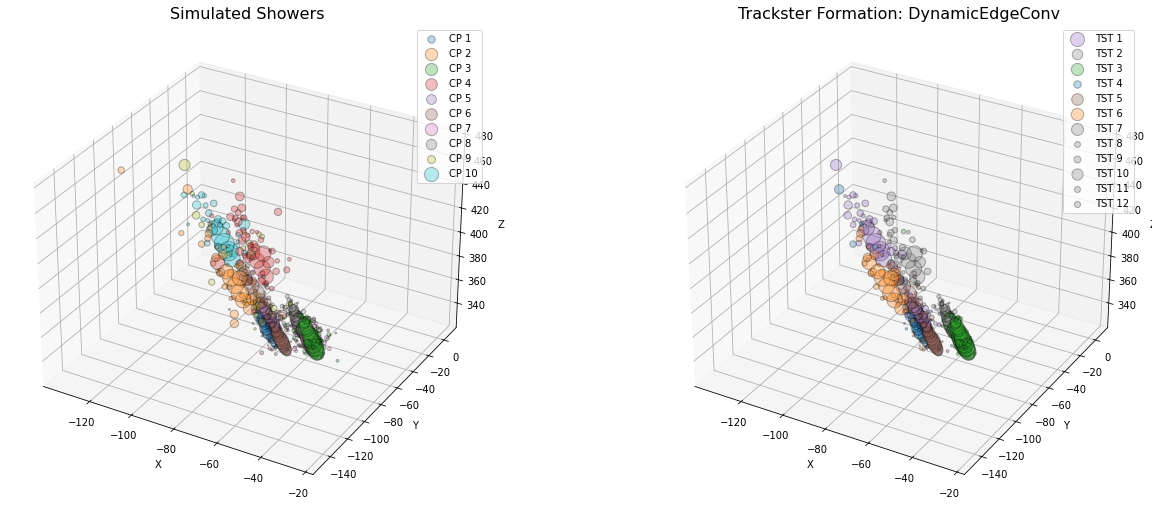

In [33]:
# Plotting longitudinal energy profiles of both simulated and reconstructed showers along with associated pairs.

import matplotlib.colors as mcolors

layer = data_file['clusters']['cluster_layer_id'].array()

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

# Ensure "plots" directory exists
os.makedirs("plots", exist_ok=True)

def calculate_event_profile_data(GT_ind, energies, recon_ind, layer, multi, event_index=0):
    """
    Creates two figures:

    1) A single 2D figure with two subplots, stacked vertically:
       - Top subplot: All Simulated (CaloParticle) showers vs. layer (1..46)
       - Bottom subplot: All Reconstructed (Trackster) showers vs. layer (1..46)
         A dashed vertical line at x=26.5 indicates the boundary between CE-E (1..26)
         and CE-H (27..46).
         All showers are EM, so all markers are triangles and legends sit on the right.

    2) A 3D figure with side-by-side subplots:
       - Left: All simulated showers in 3D
       - Right: All reconstructed showers in 3D
    """

    # ---------------------- Setup / Data Extraction ----------------------
    colors = list(mcolors.TABLEAU_COLORS.values())

    caloparticles   = GT_ind[event_index]
    tracksters      = recon_ind[event_index]
    event_energies  = energies[event_index]
    event_layer_id  = layer[event_index]
    event_multi     = multi[event_index]
    event_LC_x      = LC_x[event_index]
    event_LC_y      = LC_y[event_index]
    event_LC_z      = LC_z[event_index]

    simulated_profiles    = []
    reconstructed_profiles= []
    cp_lc_pos_all         = []
    cp_lc_energies_all    = []
    tst_lc_pos_all        = []
    tst_lc_energies_all   = []
    total_cp_energies     = []
    total_tst_energies    = []
    associations          = {}

    # Build simulated profiles
    for cp_idx, caloparticle in enumerate(caloparticles):
        cp_layers   = event_layer_id[caloparticle]
        cp_energies = event_energies[caloparticle] / event_multi[cp_idx]
        df_cp       = pd.DataFrame({'layer_id': cp_layers, 'energy': cp_energies})
        layer_cp    = df_cp.groupby('layer_id')['energy'].sum().reset_index()
        simulated_profiles.append(layer_cp)
        cp_lc_pos_all.append([event_LC_x[caloparticle],
                              event_LC_y[caloparticle],
                              event_LC_z[caloparticle]])
        cp_lc_energies_all.append(cp_energies)
        total_cp_energies.append(layer_cp['energy'].sum())

    cp_color_map = {i: colors[i % len(colors)] for i in range(len(simulated_profiles))}

    # Build reconstructed profiles
    for tst_idx, trackster in enumerate(tracksters):
        tst_layers   = event_layer_id[trackster]
        tst_energies = event_energies[trackster]
        df_tst       = pd.DataFrame({'layer_id': tst_layers, 'energy': tst_energies})
        layer_tst    = df_tst.groupby('layer_id')['energy'].sum().reset_index()
        reconstructed_profiles.append(layer_tst)
        tst_lc_pos_all.append([event_LC_x[trackster],
                               event_LC_y[trackster],
                               event_LC_z[trackster]])
        tst_lc_energies_all.append(tst_energies)
        total_tst_energies.append(layer_tst['energy'].sum())

    # Determine associations
    for cp_idx, caloparticle in enumerate(caloparticles):
        cp_E, best, max_e = total_cp_energies[cp_idx], None, 0.0
        for tst_idx, trackster in enumerate(tracksters):
            shared = set(caloparticle).intersection(trackster)
            if not shared: continue
            e_shared = np.sum(event_energies[list(shared)])
            if e_shared >= 0.5*cp_E and e_shared > max_e:
                max_e, best = e_shared, tst_idx
        if best is not None:
            associations[cp_idx] = best

    # 2D stacked plots
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(14,12), constrained_layout=True)
    fig.suptitle("Layer-Energy Profiles (CE-E vs. CE-H)", fontsize=18)

    all_energies = pd.concat(
        [p['energy'] for p in simulated_profiles] +
        [p['energy'] for p in reconstructed_profiles]
    ) if simulated_profiles or reconstructed_profiles else pd.Series([0,1])
    min_e, max_e = all_energies.min(), all_energies.max()

    def add_ce_boundary(ax):
        ax.set_xlim(1, 46)
        ax.set_ylim(min_e, max_e)
        ax.set_xlabel("Layer ID", fontsize=14)
        ax.set_ylabel("Energy [GeV]", fontsize=14)
        ax.axvline(26.5, color='black', linestyle='--', linewidth=1)
        ax.text(0.3, 0.5, "CE-E (1-26)",
                transform=ax.transAxes, ha="center", va="center",
                fontsize=12, fontweight="bold")
        ax.text(0.7, 0.5, "CE-H (27-46)",
                transform=ax.transAxes, ha="center", va="center",
                fontsize=12, fontweight="bold")

    # Top: simulated
    ax_top.set_title("Simulated Showers", fontsize=16)
    add_ce_boundary(ax_top)
    handles, labels = [], []
    for i, prof in enumerate(simulated_profiles):
        h, = ax_top.plot(
            prof['layer_id'], prof['energy'],
            marker='^', linestyle='-', color=cp_color_map[i],
            alpha=1.0, label=f"CP {i+1} (E={total_cp_energies[i]:.2f})"
        )
        handles.append(h); labels.append(h.get_label())
    ax_top.legend(handles, labels, loc='upper right', title='EM Showers')

    # Bottom: reconstructed
    ax_bottom.set_title("Trackster Formation: DynamicEdgeConv", fontsize=16)
    add_ce_boundary(ax_bottom)
    handles, labels = [], []
    for j, prof in enumerate(reconstructed_profiles):
        assoc = [cp for cp,t in associations.items() if t==j]
        color = cp_color_map[assoc[0]] if assoc else 'gray'
        lbl   = (f"TST {j+1} (E={total_tst_energies[j]:.2f}), "
                 f"matches CP {','.join(str(a+1) for a in assoc)}") \
                if assoc else f"TST {j+1} (E={total_tst_energies[j]:.2f})"
        h, = ax_bottom.plot(
            prof['layer_id'], prof['energy'],
            marker='^', linestyle='--',
            color=color, alpha=1.0, label=lbl
        )
        handles.append(h); labels.append(lbl)
    ax_bottom.legend(handles, labels, loc='upper right', title='EM Tracksters')

    fig.savefig("plots/layer_profiles.png", dpi=300, bbox_inches="tight")

    # ------------------------------ 3D VISUALIZATIONS (swapped) ------------------------------
    all_en = np.concatenate(cp_lc_energies_all + tst_lc_energies_all) \
             if cp_lc_energies_all and tst_lc_energies_all else np.array([0,1])
    xlim = [min(event_LC_x), max(event_LC_x)]
    ylim = [min(event_LC_y), max(event_LC_y)]
    zlim = [min(event_LC_z), max(event_LC_z)]

    fig3d = plt.figure(figsize=(18,7), constrained_layout=True)

    # Left: Simulated Showers
    ax_sim = fig3d.add_subplot(1, 2, 1, projection='3d')
    for i, (pos, en) in enumerate(zip(cp_lc_pos_all, cp_lc_energies_all)):
        s = np.log1p(en) * 100
        ax_sim.scatter(*pos, c=cp_color_map[i], s=s,
                       alpha=0.3, edgecolors='k', label=f"CP {i+1}")
    ax_sim.set(xlim=xlim, ylim=ylim, zlim=zlim)
    ax_sim.set_title("Simulated Showers", fontsize=16)
    ax_sim.set_xlabel("X"); ax_sim.set_ylabel("Y"); ax_sim.set_zlabel("Z")
    ax_sim.legend(loc='upper right')

    # Right: Reconstructed Showers
    ax_reco = fig3d.add_subplot(1, 2, 2, projection='3d')
    for j, (pos, en) in enumerate(zip(tst_lc_pos_all, tst_lc_energies_all)):
        s = np.log1p(en) * 100
        assoc = [cp for cp, v in associations.items() if v == j]
        c = cp_color_map[assoc[0]] if assoc else 'gray'
        ax_reco.scatter(*pos, c=c, s=s,
                        alpha=0.3, edgecolors='k', label=f"TST {j+1}")
    ax_reco.set(xlim=xlim, ylim=ylim, zlim=zlim)
    ax_reco.set_title("Trackster Formation: DynamicEdgeConv", fontsize=16)
    ax_reco.set_xlabel("X"); ax_reco.set_ylabel("Y"); ax_reco.set_zlabel("Z")
    ax_reco.legend(loc='upper right')

    fig3d.savefig("plotsDet/3D_Sim474.pdf", dpi=300, bbox_inches="tight")
    plt.show()


# Example usage:
calculate_event_profile_data(
    GT_ind_filt_nodup, energies, recon_ind_LC,
    layer, GT_mult_filt_nodup,
    event_index=474
)


In [ ]:
calculate_event_profile_data(GT_ind_filt_nodup, energies, MT_ind_filt, layer, GT_mult_filt_nodup, event_index=927)


In [ ]:
# find all indices i where pgid[i] contains only 211 and has more than 4 elements
indices = [
    i
    for i, event in enumerate(pgid)
    if len(event) > 7 and all(val == 211 for val in event)
]

print(indices)
# and to inspect, say, event 50
print(pgid[927])
